بخش اول

In [1]:
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (7, 7)

H = np.array([[1.0, 0.0],
              [0.0, 50.0]])

def cost_func(v):
    v = np.asarray(v).reshape(-1, 1)
    return 0.5 * (v.T @ H @ v).item()

def grad(v):
    v = np.asarray(v).reshape(-1, 1)
    return (H @ v).reshape(-1)

GD:

In [2]:
def gradient_descent(theta0, alpha=0.1, max_iters=100, tol=1e-6):

    theta = np.asarray(theta0, dtype=float).copy()
    path = [theta.copy()]

    for k in range(max_iters):
        g = grad(theta)
        theta_new = theta - alpha * g

        path.append(theta_new.copy())

        if np.linalg.norm(theta_new - theta) < tol:
            break

        theta = theta_new

    return np.array(path)

Newton:

In [3]:
H_inv = np.linalg.inv(H)

def newton_method(theta0, max_iters=10, tol=1e-6, alpha=1.0):

    theta = np.asarray(theta0, dtype=float).copy()
    path = [theta.copy()]

    for k in range(max_iters):
        g = grad(theta)
        step = H_inv @ g
        theta_new = theta - alpha * step

        path.append(theta_new.copy())

        if np.linalg.norm(theta_new - theta) < tol:
            break

        theta = theta_new

    return np.array(path)

Conjugate Gradient:

In [4]:
def conjugate_gradient(theta0, max_iters=10, tol=1e-8):

    x = np.asarray(theta0, dtype=float).copy()
    r = -H @ x
    p = r.copy()
    path = [x.copy()]

    for k in range(max_iters):
        Hp = H @ p
        denom = float(p @ Hp)
        if abs(denom) < 1e-15:
            break

        alpha = float(r @ r) / denom
        x_new = x + alpha * p

        r_new = r - alpha * Hp

        path.append(x_new.copy())

        if np.linalg.norm(r_new) < tol:
            break

        beta = float(r_new @ r_new) / float(r @ r)
        p = r_new + beta * p

        x, r = x_new, r_new

    return np.array(path)

GD: iterations = 200 , final theta = [-3.21753041e-03  4.11445834e-25] , cost = 5.176250965401868e-06
Newton: iterations = 2 , final theta = [0. 0.] , cost = 0.0
CG: iterations = 2 , final theta = [0.00000000e+00 5.64088706e-15] , cost = 7.954901714401577e-28


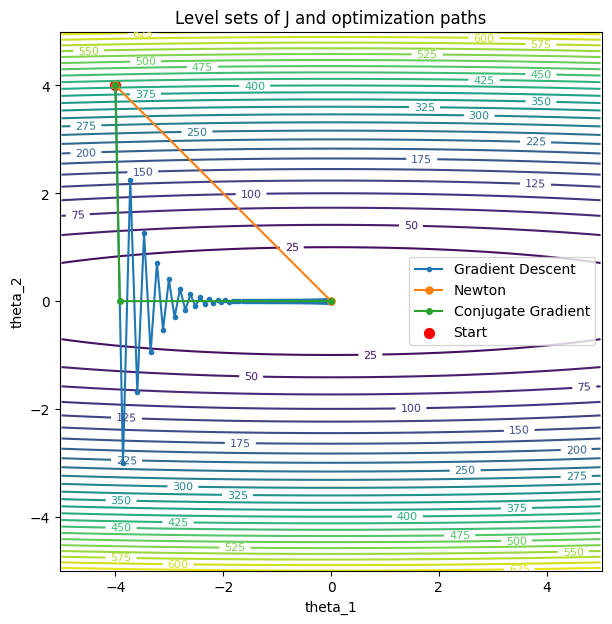

In [5]:
theta0 = np.array([-4.0, 4.0])
gd_path = gradient_descent(theta0, alpha=0.035, max_iters=200)
newton_path = newton_method(theta0, alpha=1.0, max_iters=10)
cg_path = conjugate_gradient(theta0, max_iters=10)
print("GD: iterations =", len(gd_path) - 1, ", final theta =", gd_path[-1], ", cost =", cost_func(gd_path[-1]))
print("Newton: iterations =", len(newton_path) - 1, ", final theta =", newton_path[-1], ", cost =", cost_func(newton_path[-1]))
print("CG: iterations =", len(cg_path) - 1, ", final theta =", cg_path[-1], ", cost =", cost_func(cg_path[-1]))
x1 = np.linspace(-5, 5, 200)
x2 = np.linspace(-5, 5, 200)
X1, X2 = np.meshgrid(x1, x2)

Z = np.zeros_like(X1)
for i in range(X1.shape[0]):
    for j in range(X1.shape[1]):
        v = np.array([X1[i, j], X2[i, j]])
        Z[i, j] = cost_func(v)

plt.figure()
CS = plt.contour(X1, X2, Z, levels=30)
plt.clabel(CS, inline=1, fontsize=8)

plt.plot(gd_path[:, 0], gd_path[:, 1], "-o", markersize=3, label="Gradient Descent")
plt.plot(newton_path[:, 0], newton_path[:, 1], "-o", markersize=5, label="Newton")
plt.plot(cg_path[:, 0], cg_path[:, 1], "-o", markersize=4, label="Conjugate Gradient")
plt.scatter(theta0[0], theta0[1], c="red", s=50, label="Start")
plt.xlabel("theta_1")
plt.ylabel("theta_2")
plt.title("Level sets of J and optimization paths")
plt.legend()
plt.axis("equal")
plt.show()

بخش دوم

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt

data = load_breast_cancer()
X = data.data
y = data.target

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)

class ShallowNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(30, 5)
        self.fc2 = nn.Linear(5, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        return torch.sigmoid(self.fc2(x))

model_SGD = ShallowNN()
model_LBFGS = ShallowNN()

آموزش با SGD:

In [7]:
def train_with_SGD(model, X, y, lr=0.01, epochs=200):
    criterion = nn.BCELoss()
    optimizer = optim.SGD(model.parameters(), lr=lr)

    losses = []
    times = []
    start = time.time()

    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = model(X)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()

        losses.append(loss.item())
        times.append(time.time() - start)

    return losses, times


آموزش با L-BFGS:

In [8]:
def train_with_LBFGS(model, X, y, max_iter=50):
    criterion = nn.BCELoss()
    optimizer = optim.LBFGS(model.parameters(), max_iter=max_iter, line_search_fn="strong_wolfe")

    losses = []
    times = []
    start = time.time()

    def closure():
        optimizer.zero_grad()
        outputs = model(X)
        loss = criterion(outputs, y)
        loss.backward()
        return loss

    for _ in range(max_iter):
        loss = optimizer.step(closure)
        losses.append(loss.item())
        times.append(time.time() - start)

    return losses, times


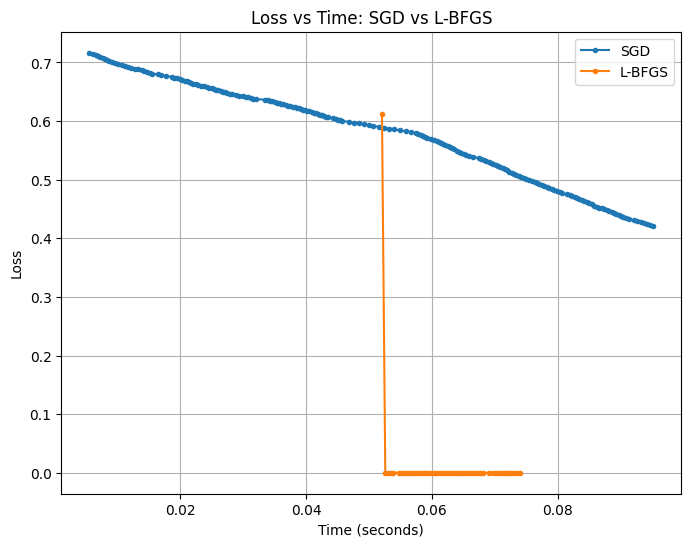

In [9]:
sgd_losses, sgd_times = train_with_SGD(model_SGD, X_train, y_train)
lbfgs_losses, lbfgs_times = train_with_LBFGS(model_LBFGS, X_train, y_train)
plt.figure(figsize=(8,6))

plt.plot(sgd_times, sgd_losses, label="SGD", marker='o', markersize=3)
plt.plot(lbfgs_times, lbfgs_losses, label="L-BFGS", marker='o', markersize=3)

plt.xlabel("Time (seconds)")
plt.ylabel("Loss")
plt.title("Loss vs Time: SGD vs L-BFGS")
plt.legend()
plt.grid(True)
plt.show()



In [10]:
results = {
    "Method": ["SGD", "L-BFGS"],
    "Final Loss": [sgd_losses[-1], lbfgs_losses[-1]],
    "Total Time (sec)": [sgd_times[-1], lbfgs_times[-1]],
    "Iterations": [len(sgd_losses), len(lbfgs_losses)]
}

df_results = pd.DataFrame(results)
df_results

,Method,Final Loss,Total Time (sec),Iterations
0,SGD,4.209679e-01,0.095197,200
1,L-BFGS,2.092802e-08,0.073996,50


بخش سوم

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
import time
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (7, 5)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])
train_dataset = datasets.MNIST(
    root="./data", train=True, download=True, transform=transform
)

batch_size = 256
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [12]:
class DeepMNISTNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28*28, 100)
        self.fc2 = nn.Linear(100, 100)
        self.fc3 = nn.Linear(100, 100)
        self.fc4 = nn.Linear(100, 10)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)
        return x

model_example = DeepMNISTNet()
N = sum(p.numel() for p in model_example.parameters())
print("Total number of parameters N =", N)

hessian_elements = N**2
hessian_bytes = hessian_elements * 4
hessian_gb = hessian_bytes / (1024**3)

print(f"Hessian size (N x N) has {hessian_elements:e} elements")
print(f"Approximate RAM needed for full Hessian (float32): {hessian_gb:.2f} GB")

Total number of parameters N = 99710
Hessian size (N x N) has 9.942084e+09 elements
Approximate RAM needed for full Hessian (float32): 37.04 GB


In [13]:
def train_model(optimizer_name="SGD", lr=0.01, epochs=10, device="cpu"):
    device = torch.device(device)

    model = DeepMNISTNet().to(device)
    criterion = nn.CrossEntropyLoss()

    if optimizer_name == "SGD":
        optimizer = optim.SGD(model.parameters(), lr=lr)
    elif optimizer_name == "Adam":
        optimizer = optim.Adam(model.parameters(), lr=lr)
    else:
        raise ValueError("optimizer_name must be 'SGD' or 'Adam'")

    losses = []
    times = []
    start_time = time.time()

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        num_batches = 0

        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            num_batches += 1

        avg_loss = running_loss / num_batches
        current_time = time.time() - start_time

        losses.append(avg_loss)
        times.append(current_time)

        print(f"[{optimizer_name}] Epoch {epoch+1}/{epochs} - Loss: {avg_loss:.4f} - Time: {current_time:.2f}s")

    return losses, times

[SGD] Epoch 1/10 - Loss: 2.2316 - Time: 9.54s
[SGD] Epoch 2/10 - Loss: 1.5089 - Time: 18.75s
[SGD] Epoch 3/10 - Loss: 0.6700 - Time: 27.45s
[SGD] Epoch 4/10 - Loss: 0.4611 - Time: 35.73s
[SGD] Epoch 5/10 - Loss: 0.3906 - Time: 44.04s
[SGD] Epoch 6/10 - Loss: 0.3552 - Time: 52.79s
[SGD] Epoch 7/10 - Loss: 0.3307 - Time: 61.39s
[SGD] Epoch 8/10 - Loss: 0.3107 - Time: 69.57s
[SGD] Epoch 9/10 - Loss: 0.2932 - Time: 78.27s
[SGD] Epoch 10/10 - Loss: 0.2778 - Time: 87.36s
[Adam] Epoch 1/10 - Loss: 0.4533 - Time: 9.16s
[Adam] Epoch 2/10 - Loss: 0.1795 - Time: 18.19s
[Adam] Epoch 3/10 - Loss: 0.1245 - Time: 26.96s
[Adam] Epoch 4/10 - Loss: 0.0931 - Time: 35.95s
[Adam] Epoch 5/10 - Loss: 0.0777 - Time: 44.90s
[Adam] Epoch 6/10 - Loss: 0.0662 - Time: 53.64s
[Adam] Epoch 7/10 - Loss: 0.0519 - Time: 62.22s
[Adam] Epoch 8/10 - Loss: 0.0463 - Time: 71.30s
[Adam] Epoch 9/10 - Loss: 0.0403 - Time: 80.42s
[Adam] Epoch 10/10 - Loss: 0.0324 - Time: 89.80s


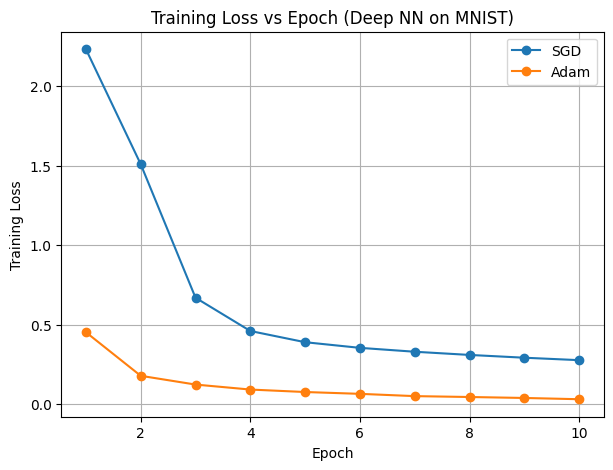

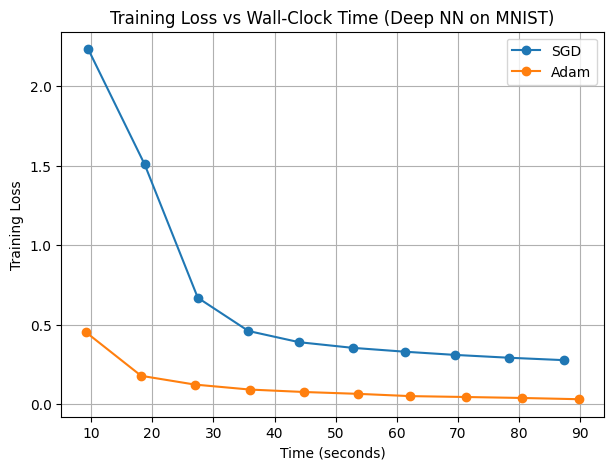

In [14]:
epochs = 10
sgd_losses, sgd_times = train_model(optimizer_name="SGD", lr=0.01, epochs=epochs)
adam_losses, adam_times = train_model(optimizer_name="Adam", lr=0.001, epochs=epochs)

plt.figure()
plt.plot(range(1, epochs+1), sgd_losses, "-o", label="SGD")
plt.plot(range(1, epochs+1), adam_losses, "-o", label="Adam")
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("Training Loss vs Epoch (Deep NN on MNIST)")
plt.legend()
plt.grid(True)
plt.show()

plt.figure()
plt.plot(sgd_times, sgd_losses, "-o", label="SGD")
plt.plot(adam_times, adam_losses, "-o", label="Adam")
plt.xlabel("Time (seconds)")
plt.ylabel("Training Loss")
plt.title("Training Loss vs Wall-Clock Time (Deep NN on MNIST)")
plt.legend()
plt.grid(True)
plt.show()

بخش چهارم

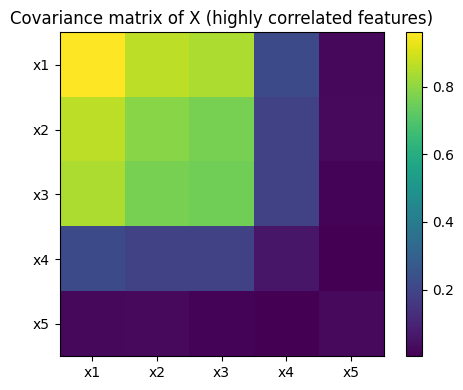

In [15]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(42)
n_samples = 1000
n_features = 5
z = np.random.randn(n_samples, 1)
x1 = z + 0.1 * np.random.randn(n_samples, 1)
x2 = 0.9 * x1 + 0.1 * np.random.randn(n_samples, 1)
x3 = 0.7 * x1 + 0.2 * x2 + 0.1 * np.random.randn(n_samples, 1)
x4 = 0.5 * x1 - 0.3 * x2 + 0.1 * np.random.randn(n_samples, 1)
x5 = x2 - x3 + 0.1 * np.random.randn(n_samples, 1)
X = np.hstack([x1, x2, x3, x4, x5])
cov_matrix = np.cov(X, rowvar=False)
plt.figure(figsize=(5, 4))
im = plt.imshow(cov_matrix, cmap="viridis")
plt.colorbar(im)
plt.title("Covariance matrix of X (highly correlated features)")
plt.xticks(range(n_features), [f"x{i+1}" for i in range(n_features)])
plt.yticks(range(n_features), [f"x{i+1}" for i in range(n_features)])
plt.tight_layout()
plt.show()

In [16]:
Q, R = np.linalg.qr(X, mode="reduced")

print("X shape:", X.shape)
print("Q shape:", Q.shape)
print("R shape:", R.shape)

QtQ = Q.T @ Q
print("\nQ^T Q (should be close to Identity matrix):")
print(QtQ)


X shape: (1000, 5)
Q shape: (1000, 5)
R shape: (5, 5)

Q^T Q (should be close to Identity matrix):
[[ 1.00000000e+00 -2.60208521e-18 -1.73472348e-17 -1.47451495e-17
   1.38777878e-17]
 [-2.60208521e-18  1.00000000e+00 -1.38777878e-17 -2.08166817e-17
  -7.58941521e-18]
 [-1.73472348e-17 -1.38777878e-17  1.00000000e+00  2.60208521e-18
  -1.04083409e-17]
 [-1.47451495e-17 -2.08166817e-17  2.60208521e-18  1.00000000e+00
  -3.81639165e-17]
 [ 1.38777878e-17 -7.58941521e-18 -1.04083409e-17 -3.81639165e-17
   1.00000000e+00]]


Final loss on X: 0.17657360151024665
Final loss on Q: 0.13098639764243497


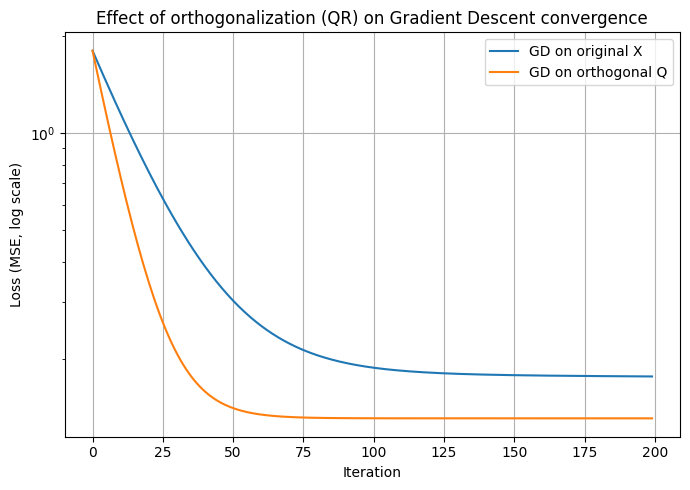

In [17]:
w_true = np.array([2.0, -1.0, 0.5, 1.5, -0.7])
y = X @ w_true + 0.5 * np.random.randn(n_samples)

def gradient_descent_linear(X, y, lr=0.01, n_iters=200):
    n_samples, n_features = X.shape
    w = np.zeros(n_features)
    losses = []

    for _ in range(n_iters):
        y_pred = X @ w
        error = y_pred - y
        grad = (1.0 / n_samples) * (X.T @ error)
        w = w - lr * grad

        loss = 0.5 * np.mean(error**2)
        losses.append(loss)

    return w, np.array(losses)

n_iters = 200
lr_X = 0.01
lr_Q = 50.0

w_X, losses_X = gradient_descent_linear(X, y, lr=lr_X, n_iters=n_iters)
w_Q, losses_Q = gradient_descent_linear(Q, y, lr=lr_Q, n_iters=n_iters)

print("Final loss on X:", losses_X[-1])
print("Final loss on Q:", losses_Q[-1])

plt.figure(figsize=(7,5))
plt.semilogy(losses_X, label="GD on original X")
plt.semilogy(losses_Q, label="GD on orthogonal Q")
plt.xlabel("Iteration")
plt.ylabel("Loss (MSE, log scale)")
plt.title("Effect of orthogonalization (QR) on Gradient Descent convergence")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()